___
# Predictive Power - Interest rates versus GDP Growth
___

### TOC
- [Intro](#intro)
- [Method](#method)

The concensus is that change in interest rates leads to changes in GDP Growth. Given the theoretical paradigm upon which economic thought and activity is based, this makes perfect sense; the more expensive money is, the less people buy it and vice verca. In particular, monetary policy is the big societal application of this idea. While it makes perfect valid sense in the paradigm, there is reason to doubt that this idea is actually sound. For example:

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

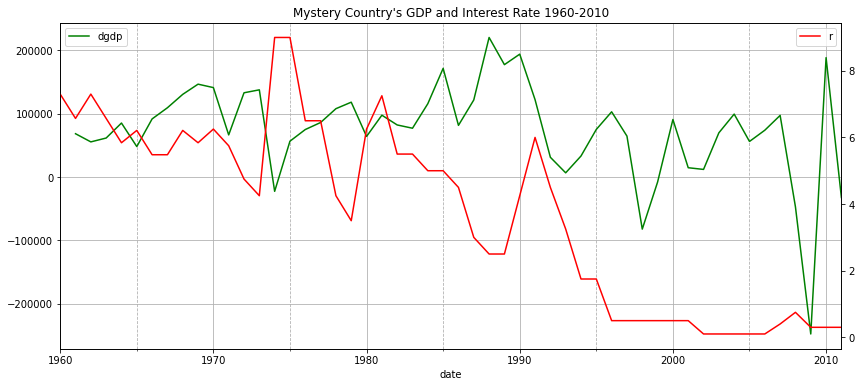

In [32]:
# --- Grab gdp and interest rates

path = "data/r_gdp_jp/"
start_date = dt.datetime.strptime("1960-01-01", "%Y-%m-%d")

gdp = pd.read_csv(path + "gdp.csv").rename(columns={"DATE" : "date", "JPNRGDPR" : "gdp"})
r = pd.read_csv(path + "interest_rate.csv").rename(columns={"DATE":"date","INTDSRJPM193N":"r"})
gdp.date = pd.to_datetime(gdp.date)
r.date = pd.to_datetime(r.date)
r = r.loc[r.date.isin(gdp.date.values)]
r = r.loc[r.date >= start_date].set_index("date")
gdp = gdp.set_index("date")
eg_1 = pd.concat([gdp, r], axis=1)

# --- Calculate GDP growth

eg_1["dgdp"] = eg_1.gdp - eg_1.gdp.shift(1)

# --- Plot

_, ax1 = plt.subplots(1, figsize=(14, 6))
ax2 = ax1.twinx()
eg_1.plot(y="dgdp", c="g", ax=ax1);
eg_1.plot(y="r", c="r", ax=ax2);
ax1.legend(loc="upper left");
ax1.grid(which="major", linestyle="-")
ax1.grid(which="minor", linestyle="--")
ax1.set(title="Mystery Country's GDP and Interest Rate 1960-2010");

___
## Intro <a id="intro"></a>
___
Assuming you didn't read the code, this mystery country's nominal GDP growth (in green) and interest rate (red) appears to be a counter example. There are parts of this plot that appear to be in line with the theory. Looking at some examples, falling r from 1960 until before that spike in 1973ish, accelerating (since $\delta$GDP is already a rate of change) GDP growth coincides with declining r, and then the spike that follows directly after coincides with a large decelerating impulse in GDP growth. It all more or less looks fine until just before 1990 where things stop working. This is the infamous macroeconomic mystery of Japanese nominal GDP growth and interest rate.

The paper below, which is the inspriation for this exercise in analysis and gesticulation, goes into more depth and examples so I won't spend too much time here, but I did want to raise a quote in the paper to our attention:

> As an empirical matter, low interest rates are a sign that monetary policy has been tight - in the sense that the quantity of money has grown slowly; high interest rates are a sign that monetary policy has been easy - in the sense that the quantity of money has grown rapidly. The broadest facts of experience run in precisely the opposite direction from that which the financial community and acedemic economists have all generally taken for granted.
>
> – Milton Friedman, 1968


[Werner](https://www.sciencedirect.com/science/article/pii/S0921800916307510) does the work for the first time of sorting out the empirical evidence, but I wanted to see if my fast-and-loose approach can capture some of what Werner's more rigorous study has. What would constitute a success herein would be if I can show with my primitive sticks and stones and minimal knowledge of statistics that one could be suspicious of the hypothesis that interest rates determine GDP growth. If I can return an "inconclusive" after trying to reject the hypothesis, I'll take that as a win. In particular, I'm quite curious about predictive power - whether or not [PPS](https://8080labs.com/blog/posts/rip-correlation-introducing-the-predictive-power-score-pps/) out of the box has something to say either in favour of or agaisnt the $H_0$, and i'm also interested in trying my hand at [Granger causality](https://en.wikipedia.org/wiki/Granger_causality). These two things could work syngergistically  It's also something I want to apply across to my health data as well, so this is the perfect exercise for it.

In the study, a few countries are put under the test - Germany, Japan, United Kingdom, United States, and it is found that all but Germany comfortably destroy the $H_0$. In the case of Germay, it is only vigorously shaken. Since the questions in question are with regards to the journey and the start and end points are part of the assumptions, whatever I yield on the Germany, given that I take it on assumption to be diffferent, should be an interesting point of reference.

## Riff off his Method <a id="method"></a>

I'm going to roughly rip off his method, and just modify bits and pieces to see if I can fill in the gaps. Thus, for German, Japanese and American data:
1. Assess correlations between GDP growth and interest rates ( + maybe bond yields as a proxy)
2. Assess the above but with some lag in either direction
3. Repeat the two above steps but with PPS
4. Do a granger causality and contextualise the relevant statistics
5. Think about doing the same for a quantitive variable? Delta quantity of money.